In [1]:
import os
import warnings
os.environ['PYTHONWARNINGS'] = 'ignore::FutureWarning'

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold, cross_val_predict, GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, confusion_matrix, make_scorer, roc_curve, auc
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split


In [2]:
# Read in data from previous closure
previous_data = pd.read_csv('employee_attrition_previous_closure.csv')
previous_data.head()

,Attrition,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,No,50.0,Travel_Rarely,1126.0,Research & Development,1.0,2,Medical,1,997,...,3,80,1,32,1,2,5,4,1,3
1,No,36.0,Travel_Rarely,216.0,Research & Development,6.0,2,Medical,1,178,...,4,80,2,7,0,3,3,2,0,1
2,Yes,21.0,Travel_Rarely,337.0,Sales,7.0,1,Marketing,1,1780,...,2,80,0,1,3,3,1,0,1,0
3,No,50.0,Travel_Frequently,1246.0,Human Resources,NaN,3,Medical,1,644,...,3,80,1,32,2,3,32,5,10,7
4,No,52.0,Travel_Rarely,994.0,Research & Development,7.0,4,Life Sciences,1,1118,...,4,80,0,18,4,3,8,6,4,0


# EDA of data used for prediction model

In [3]:
# Check the structure of the dataset
print(previous_data.info())

# Examine missing values in each column
print(previous_data.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1029 entries, 0 to 1028
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Attrition                 1029 non-null   object 
 1   Age                       893 non-null    float64
 2   BusinessTravel            1024 non-null   object 
 3   DailyRate                 1002 non-null   float64
 4   Department                1029 non-null   object 
 5   DistanceFromHome          934 non-null    float64
 6   Education                 1029 non-null   int64  
 7   EducationField            1029 non-null   object 
 8   EmployeeCount             1029 non-null   int64  
 9   EmployeeNumber            1029 non-null   int64  
 10  EnvironmentSatisfaction   1029 non-null   int64  
 11  Gender                    1029 non-null   object 
 12  HourlyRate                1029 non-null   int64  
 13  JobInvolvement            1029 non-null   int64  
 14  JobLevel

In [4]:
# statistical summary of numerical features
previous_data.describe()

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,893.000000,1002.000000,934.000000,1029.000000,1029.0,1029.000000,1029.000000,1029.000000,1029.000000,1029.000000,...,1029.000000,1029.0,1029.000000,1029.000000,1029.000000,1029.000000,1029.000000,1029.000000,1029.000000,1029.000000
mean,37.930571,800.528942,9.930407,2.892128,1.0,1024.367347,2.683188,66.680272,2.713314,2.043732,...,2.689990,80.0,0.822157,11.196307,2.782313,2.748299,6.942663,4.215743,2.119534,4.005831
std,9.395978,408.109828,8.421791,1.053541,0.0,606.301635,1.096829,20.474094,0.710146,1.118918,...,1.077767,0.0,0.874662,7.857581,1.283401,0.697278,6.068322,3.658595,3.108651,3.522574
min,18.000000,102.000000,1.000000,1.000000,1.0,1.000000,1.000000,30.000000,1.000000,1.000000,...,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,31.000000,458.250000,2.000000,2.000000,1.0,496.000000,2.000000,48.000000,2.000000,1.000000,...,2.000000,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,37.000000,801.500000,8.000000,3.000000,1.0,1019.000000,3.000000,67.000000,3.000000,2.000000,...,3.000000,80.0,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,44.000000,1162.000000,16.000000,4.000000,1.0,1553.000000,4.000000,84.000000,3.000000,3.000000,...,4.000000,80.0,1.000000,15.000000,3.000000,3.000000,10.000000,7.000000,2.000000,7.000000
max,60.000000,1496.000000,29.000000,5.000000,1.0,2068.000000,4.000000,100.000000,4.000000,5.000000,...,4.000000,80.0,3.000000,40.000000,6.000000,4.000000,37.000000,18.000000,15.000000,17.000000


In [5]:
# Function for one-hot encoding categorical features
def one_hot_encode(df):
    # Make a copy to avoid modifying the original dataframe
    df_encoded = df.copy()
    
    # Get list of categorical columns
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    
    print(f"Categorical columns to encode: {categorical_cols}")
    
    # Apply one-hot encoding, dropping first category to prevent multicollinearity
    df_encoded = pd.get_dummies(df_encoded, columns=categorical_cols, drop_first=True, dtype=int)
    
    print(f"Shape before encoding: {df.shape}")
    print(f"Shape after encoding: {df_encoded.shape}")
    
    return df_encoded

# Encode categorical features in the dataset
print("\nOne-hot encoding categorical features for previous_data:")
previous_data_encoded = one_hot_encode(previous_data)


previous_data_encoded.head()



One-hot encoding categorical features for previous_data:
Categorical columns to encode: ['Attrition', 'BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'Over18', 'OverTime']
Shape before encoding: (1029, 35)
Shape after encoding: (1029, 48)


,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes
0,50.0,1126.0,1.0,2,1,997,4,66,3,4,...,0,0,0,1,0,0,0,0,0,0
1,36.0,216.0,6.0,2,1,178,2,84,3,2,...,0,0,1,0,0,0,0,0,0,0
2,21.0,337.0,7.0,1,1,1780,2,31,3,1,...,0,0,0,0,0,0,1,0,1,0
3,50.0,1246.0,NaN,3,1,644,1,99,3,5,...,0,1,0,0,0,0,0,1,0,0
4,52.0,994.0,7.0,4,1,1118,2,87,3,3,...,0,0,0,0,0,0,0,0,1,0


In [6]:
# Impute missing values with mean
print("\nFilling NA values with mean in encoded dataframe:")
previous_data_encoded_clean = previous_data_encoded.fillna(previous_data_encoded.mean())
# Check data shape before and after imputation
print(f"Shape before filling NA: {previous_data_encoded.shape}")
print(f"Shape after filling NA: {previous_data_encoded_clean.shape}")
# Count the number of missing values that were filled
print(f"Number of NA values filled: {previous_data_encoded.isna().sum().sum()}")

# Remove constant or non-informative columns
print("\nDropping EmployeeCount, EmployeeNumber, StandardHours columns:")
columns_to_drop = ['EmployeeCount', 'EmployeeNumber', 'StandardHours']
previous_data_encoded_clean = previous_data_encoded_clean.drop(columns=columns_to_drop, errors='ignore')
# Verify final data shape after column removal
print(f"Shape after dropping specified columns: {previous_data_encoded_clean.shape}")



Filling NA values with mean in encoded dataframe:
Shape before filling NA: (1029, 48)
Shape after filling NA: (1029, 48)
Number of NA values filled: 258

Dropping EmployeeCount, EmployeeNumber, StandardHours columns:
Shape after dropping specified columns: (1029, 45)


In [7]:
# Calculate skewness for all encoded features
print("\nSkewness for encoded features:")
skewness_encoded = previous_data_encoded_clean.skew().round(2)
print(skewness_encoded.sort_values(ascending=False))

# Extract features with high skewness (absolute value > 1)
print("\nHighly skewed encoded features (|skewness| > 1):")
highly_skewed = skewness_encoded[abs(skewness_encoded) > 1].sort_values(ascending=False)
print(highly_skewed)

# Analyze distribution of skewness across features
pos_skew = sum(skewness_encoded > 0)
neg_skew = sum(skewness_encoded < 0)
print(f"\nNumber of positively skewed features: {pos_skew}")
print(f"Number of negatively skewed features: {neg_skew}")
print(f"Number of highly skewed features (|skewness| > 1): {len(highly_skewed)}")



Skewness for encoded features:
JobRole_Human Resources              5.23
JobRole_Research Director            3.70
EducationField_Other                 3.56
JobRole_Sales Representative         3.56
JobRole_Manager                      3.35
EducationField_Technical Degree      3.11
JobRole_Manufacturing Director       2.82
EducationField_Marketing             2.55
YearsSinceLastPromotion              1.95
PerformanceRating                    1.86
Attrition_Yes                        1.75
JobRole_Laboratory Technician        1.72
YearsAtCompany                       1.67
BusinessTravel_Travel_Frequently     1.55
JobRole_Research Scientist           1.44
JobRole_Sales Executive              1.42
MonthlyIncome                        1.35
TotalWorkingYears                    1.08
NumCompaniesWorked                   1.07
JobLevel                             1.02
StockOptionLevel                     0.96
YearsInCurrentRole                   0.96
OverTime_Yes                         0.93
Ye

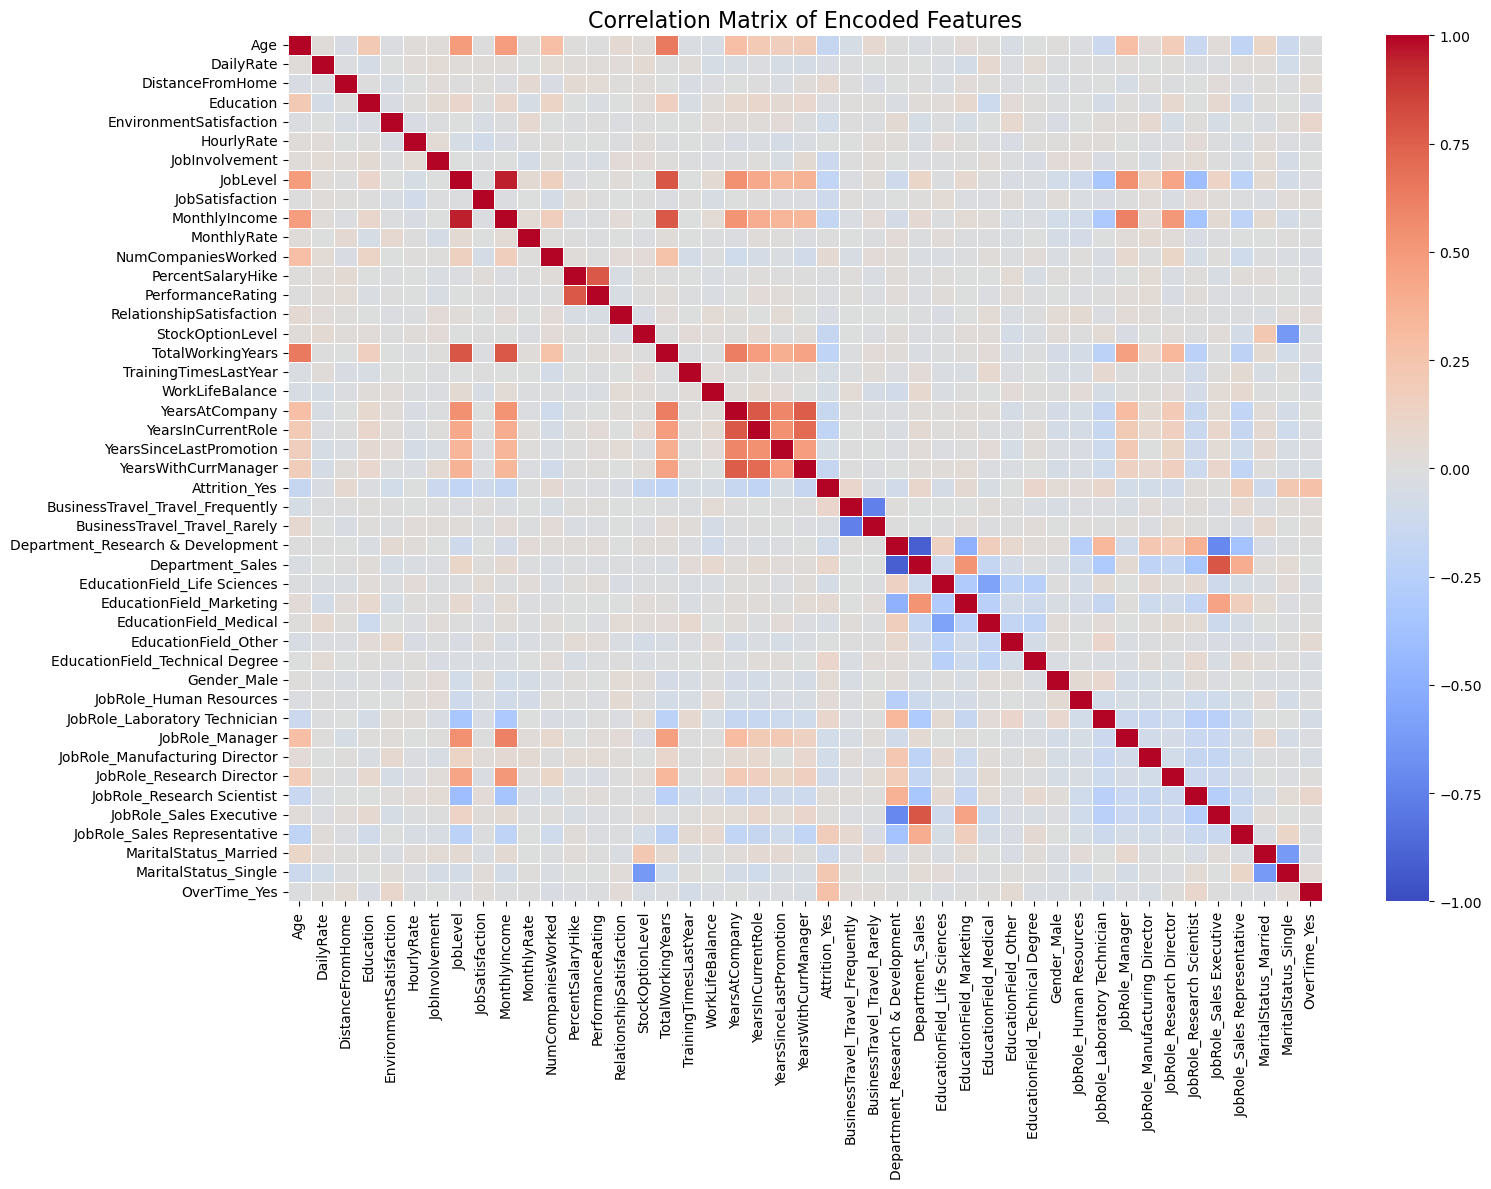


Features most correlated with Attrition:
Attrition_Yes                       1.000000
OverTime_Yes                        0.273295
MaritalStatus_Single                0.224511
JobRole_Sales Representative        0.176040
BusinessTravel_Travel_Frequently    0.097778
EducationField_Technical Degree     0.095061
JobRole_Laboratory Technician       0.091123
Department_Sales                    0.088834
DistanceFromHome                    0.062524
NumCompaniesWorked                  0.061832
Name: Attrition_Yes, dtype: float64

Feature pairs with high correlation (potential multicollinearity):
JobLevel -- MonthlyIncome: 0.953
Department_Research & Development -- Department_Sales: -0.911
JobLevel -- TotalWorkingYears: 0.786
Department_Sales -- JobRole_Sales Executive: 0.785
YearsAtCompany -- YearsInCurrentRole: 0.778
PercentSalaryHike -- PerformanceRating: 0.774
MonthlyIncome -- TotalWorkingYears: 0.773
YearsAtCompany -- YearsWithCurrManager: 0.760
BusinessTravel_Travel_Frequently -- Busines

In [8]:
# Calculate correlation matrix for all features
correlation_matrix = previous_data_encoded_clean.corr()

# Create visualization with appropriate dimensions
plt.figure(figsize=(16, 12))

# Generate heatmap of correlations
sns.heatmap(correlation_matrix, 
            annot=False,  # Annotations disabled due to large feature count
            cmap='coolwarm', 
            vmin=-1, 
            vmax=1, 
            center=0,
            linewidths=0.5)

plt.title('Correlation Matrix of Encoded Features', fontsize=16)
plt.tight_layout()
plt.show()

# Identify features most correlated with attrition
target_correlations = correlation_matrix['Attrition_Yes'].sort_values(ascending=False)
print("\nFeatures most correlated with Attrition:")
print(target_correlations.head(10))

# Examine feature multicollinearity
# Create upper triangle mask for correlation matrix
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
high_correlations = []

# Extract feature pairs with correlation exceeding 0.7 threshold
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.7:
            high_correlations.append((
                correlation_matrix.columns[i], 
                correlation_matrix.columns[j], 
                correlation_matrix.iloc[i, j]
            ))

# Order by correlation strength
high_correlations.sort(key=lambda x: abs(x[2]), reverse=True)

# Display highly correlated feature pairs
if high_correlations:
    print("\nFeature pairs with high correlation (potential multicollinearity):")
    for feat1, feat2, corr in high_correlations[:15]:  # Display top 15 pairs
        print(f"{feat1} -- {feat2}: {corr:.3f}")
else:
    print("\nNo feature pairs with correlation > 0.7 found.")


In [9]:
# Preparing data for VIF calculations
X_for_vif = previous_data_encoded_clean.drop('Attrition_Yes', axis=1)

# Computing VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X_for_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_for_vif.values, i) for i in range(X_for_vif.shape[1])]

# Sorting VIF values in descending order
vif_data = vif_data.sort_values("VIF", ascending=False)

# Displaying VIF results
print("\nVariance Inflation Factor (VIF) for each feature:")
print("VIF > 10 indicates high multicollinearity")
print(vif_data)



Variance Inflation Factor (VIF) for each feature:
VIF > 10 indicates high multicollinearity
                              Feature         VIF
13                  PerformanceRating  159.744009
25  Department_Research & Development   92.611424
7                            JobLevel   65.875782
9                       MonthlyIncome   53.571284
26                   Department_Sales   50.667181
12                  PercentSalaryHike   45.393775
27       EducationField_Life Sciences   43.013313
0                                 Age   36.762525
29             EducationField_Medical   33.176876
39            JobRole_Sales Executive   16.997258
18                    WorkLifeBalance   16.553640
6                      JobInvolvement   15.587036
16                  TotalWorkingYears   14.559707
28           EducationField_Marketing   12.583258
5                          HourlyRate   11.783082
19                     YearsAtCompany   11.150645
3                           Education    9.261745
31    E

### I choose to retain skewed features and allow for multicollinearity, as models like Random Forest do not rely on normality or feature independence. Even for logistic regression, I apply dimensionality reduction or regularization where needed through preprocessing pipelines. Moreover, due to limited domain knowledge, I avoid manually excluding features to reduce the risk of discarding potentially important information.


# Prediction Model

In [10]:
# Separate features and target variable
X = previous_data_encoded_clean.drop('Attrition_Yes', axis=1)
y = previous_data_encoded_clean['Attrition_Yes']

# Create train-test split with stratification to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize features to have zero mean and unit variance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Set up cross-validation strategy for model evaluation
n_splits = 5
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

## Multiple models and parameter configurations were tested, with Logistic Regression and Random Forest emerging as the most suitable. Logistic Regression offers interpretability and performs well with high-dimensional, sparse data, while Random Forest captures complex, non-linear relationships and is robust to multicollinearity and feature interactions. It also outperformed other ensemble methods such as boosting and bagging, as well as classifiers like SVM, LDA, and Naive Bayes. Together, these two models provide a strong balance between transparency and predictive performance, making them well-suited for this classification task.


Fitting 5 folds for each of 64 candidates, totalling 320 fits

Random Forest Best Parameters:
{'model__bootstrap': True, 'model__class_weight': 'balanced', 'model__criterion': 'gini', 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 4, 'model__min_samples_split': 2, 'model__n_estimators': 200, 'smote__k_neighbors': 5, 'smote__sampling_strategy': 'auto'}

Random Forest Pipeline Performance (Cross-Validation on Training Data):
Accuracy: 0.8505
Precision: 0.6216
Recall: 0.3262
F1 Score: 0.4279
ROC AUC: 0.7951
Confusion Matrix (CV):
[[654  28]
 [ 95  46]]

Random Forest Feature Importance (Top 15):
                    Feature  Importance
43             OverTime_Yes    0.138741
15         StockOptionLevel    0.063787
22     YearsWithCurrManager    0.053233
42     MaritalStatus_Single    0.047666
6            JobInvolvement    0.045519
16        TotalWorkingYears    0.044670
9             MonthlyIncome    0.043644
20       YearsInCurrentRole    0.043255
19 

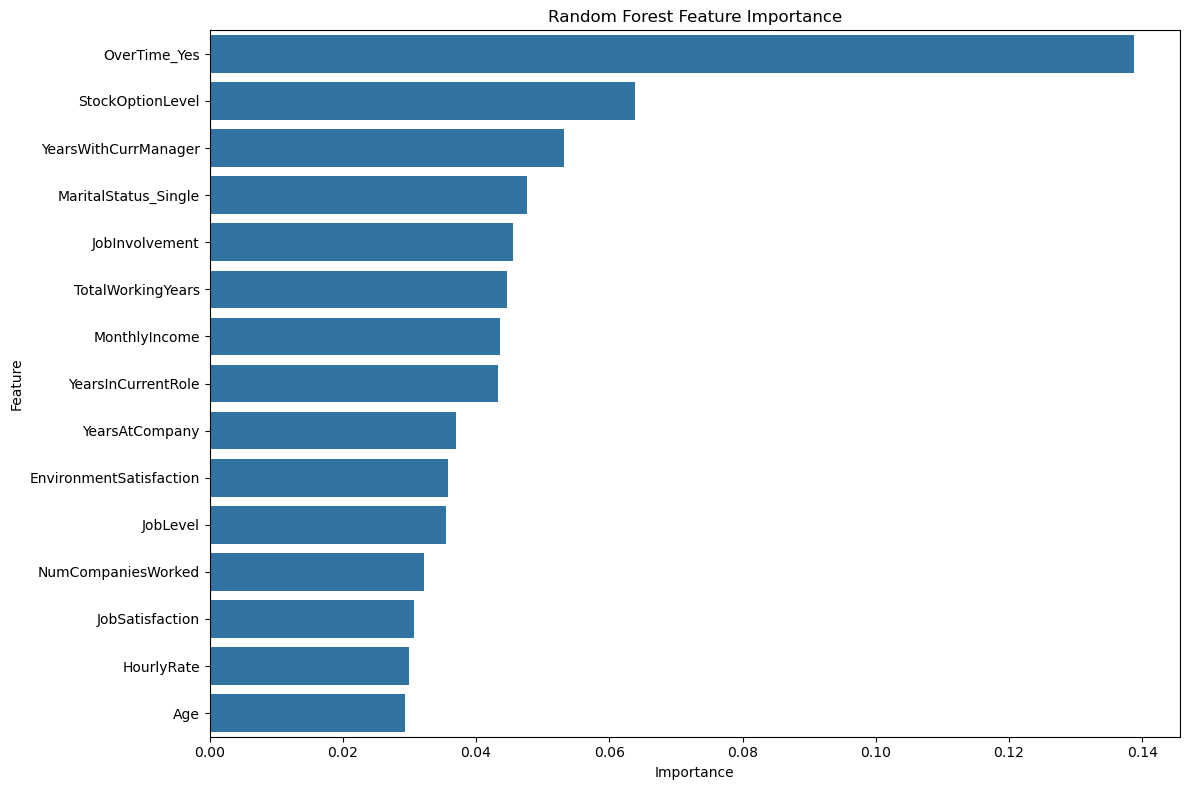

Fitting 5 folds for each of 30 candidates, totalling 150 fits

Logistic Regression Best Parameters:
{'model__C': 1.0, 'model__class_weight': 'balanced', 'model__penalty': 'l2', 'model__solver': 'saga', 'pca__n_components': None, 'smote__k_neighbors': 5, 'smote__sampling_strategy': 0.7}

Logistic Regression Pipeline Performance (Cross-Validation on Training Data):
Accuracy: 0.7886
Precision: 0.4279
Recall: 0.6950
F1 Score: 0.5297
ROC AUC: 0.8119
Confusion Matrix (CV):
[[551 131]
 [ 43  98]]

Logistic Regression Feature Importance (Top 15):
                          Feature  Coefficient
38     JobRole_Research Scientist     1.226057
39        JobRole_Sales Executive     1.085530
14       RelationshipSatisfaction     1.013220
41          MaritalStatus_Married     0.949917
34  JobRole_Laboratory Technician     0.863198
30           EducationField_Other     0.740090
0                             Age     0.717600
40   JobRole_Sales Representative     0.621847
27   EducationField_Life Science

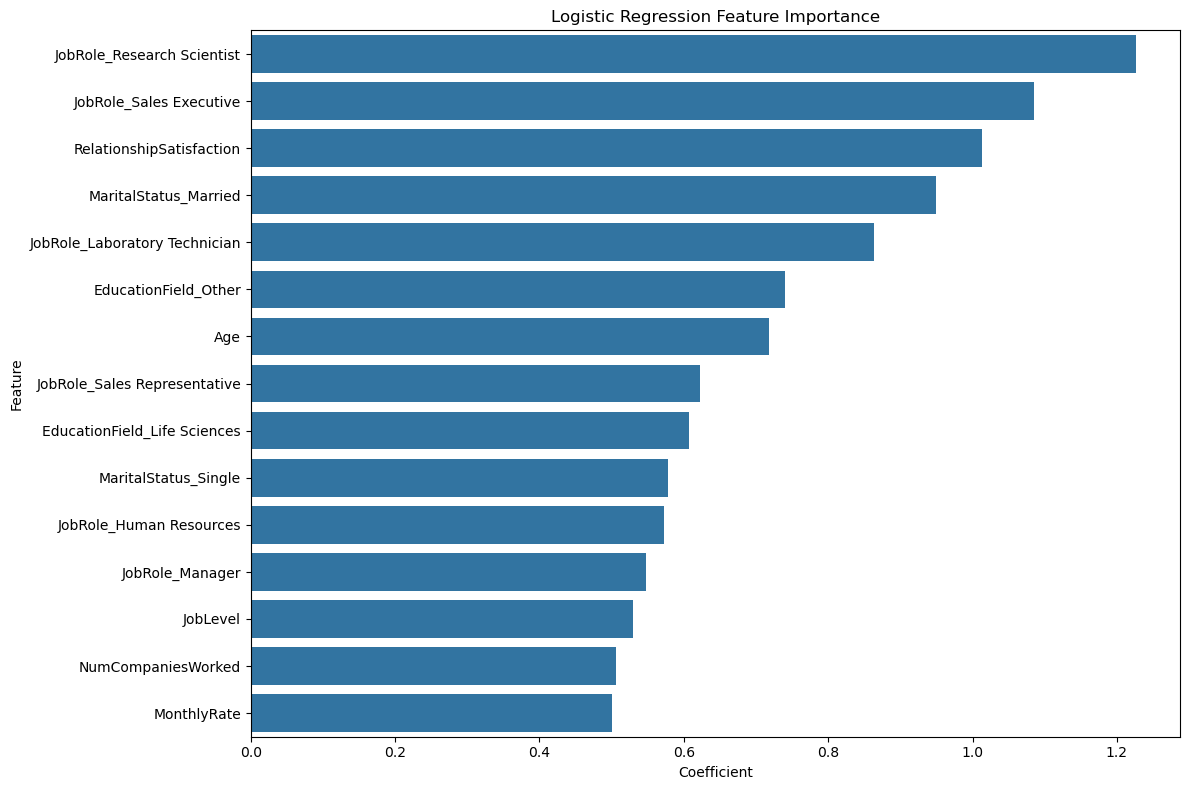

In [11]:
warnings.filterwarnings("ignore")

# Define scoring metrics
scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score, needs_proba=True)  # Ensure ROC AUC uses probabilities
}

# Define the pipelines with parameter grids for GridSearchCV

# Using imbalanced-learn Pipeline to incorporate SMOTE
# Random Forest pipeline with enhanced parameters for imbalanced data
rf_pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),  # Address class imbalance
    ('model', RandomForestClassifier(random_state=42))
])
rf_param_grid = {
    # SMOTE parameters for handling imbalanced data
    'smote__k_neighbors': [5],
    'smote__sampling_strategy': ['auto', 0.8],  # 'auto' for equal classes, 0.8 for slight imbalance retention
    
    # Random Forest parameters optimized for employee attrition prediction
    'model__n_estimators': [100, 200],  # Sufficient trees for stability without excessive computation
    'model__max_depth': [None, 20],  # Control model complexity
    'model__min_samples_split': [2, 5],  # Prevent overfitting on HR data
    'model__min_samples_leaf': [1, 4],  # Balance between detail capture and generalization
    'model__max_features': ['sqrt', 'log2'],  # Feature subset selection methods
    'model__class_weight': ['balanced'],  # Critical for handling imbalanced attrition data
    'model__bootstrap': [True],  # Enable feature importance estimation
    'model__criterion': ['gini']  # Faster computation than entropy
}

# Logistic Regression pipeline with PCA for dimensionality reduction
# LR works well for interpretable binary classification problems like attrition
lr_pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),  # Balance classes
    ('pca', PCA(random_state=42)),      # Reduce multicollinearity in HR features
    ('model', LogisticRegression(random_state=42, max_iter=2000))  # Increased iterations for convergence
])
lr_param_grid = {
    # SMOTE parameters
    'smote__k_neighbors': [5],
    'smote__sampling_strategy': ['auto', 0.5, 0.6, 0.7,0.8],
    
    # PCA parameters - dimensionality reduction helps with multicollinearity
    'pca__n_components': [0.8, None],  # 0.8 retains 80% variance, None keeps all components
    
    # Logistic Regression parameters
    'model__C': [0.1, 1.0, 10.0],  # Regularization strength - critical for HR data with many features
    'model__penalty': ['l2'],      # L2 regularization to handle correlated HR metrics
    'model__solver': ['saga'],     # Efficient solver for L1 and L2 penalties
    'model__class_weight': ['balanced'],  # Account for imbalanced attrition data
}

# Dictionary of pipelines for evaluation
pipelines = {
    'Random Forest': (rf_pipeline, rf_param_grid),
    'Logistic Regression': (lr_pipeline, lr_param_grid)
}

best_models = {}

# Evaluate each pipeline with GridSearchCV
for name, (pipeline, param_grid) in pipelines.items():
    # Use GridSearchCV to find the best parameters
    grid_search = GridSearchCV(
        pipeline, 
        param_grid, 
        cv=cv, 
        scoring='f1',  
        n_jobs=-1,    
        verbose=1,
        error_score=np.nan
    )
    
    # Fit the grid search on the training data
    grid_search.fit(X_train_scaled, y_train)
    
    # Get the best model
    best_model = grid_search.best_estimator_
    best_models[name] = best_model
    
    # Print the best parameters
    print(f"\n{name} Best Parameters:")
    print(grid_search.best_params_)
    
    # Get predictions for evaluation metrics using cross-validation on training data
    y_pred = cross_val_predict(best_model, X_train_scaled, y_train, cv=cv)
    
    # Calculate metrics on training data with cross-validation
    accuracy = accuracy_score(y_train, y_pred)
    precision = precision_score(y_train, y_pred)
    recall = recall_score(y_train, y_pred)
    f1 = f1_score(y_train, y_pred)
    
    # Get probability predictions for ROC AUC
    y_score = cross_val_predict(best_model, X_train_scaled, y_train, cv=cv, method='predict_proba')[:, 1]
    roc_auc = roc_auc_score(y_train, y_score)
    
    # Print the cross-validation results
    print(f"\n{name} Pipeline Performance (Cross-Validation on Training Data):")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    
    # Display confusion matrix values for cross-validation
    cm = confusion_matrix(y_train, y_pred)
    print(f"Confusion Matrix (CV):\n{cm}")
    
    # Fit the best model on the entire training dataset
    best_model.fit(X_train_scaled, y_train)
    
    # Extract and display feature importance
    if name == 'Random Forest':
        # For Random Forest, we can directly get feature importances
        feature_importances = best_model.named_steps['model'].feature_importances_
        feature_names = X_train.columns
        
        # Create a DataFrame for better visualization
        importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': feature_importances
        }).sort_values('Importance', ascending=False)
        
        print(f"\n{name} Feature Importance (Top 15):")
        print(importance_df.head(15))
        
        # Visualize feature importance
        plt.figure(figsize=(12, 8))
        sns.barplot(x='Importance', y='Feature', data=importance_df.head(15))
        plt.title(f'{name} Feature Importance')
        plt.tight_layout()
        plt.show()
        
    elif name == 'Logistic Regression':
        # For Logistic Regression with PCA, we need to handle differently
        # Check if PCA was used (n_components is not None)
        if best_model.named_steps['pca'].n_components_ < X_train.shape[1]:
            # PCA was used, so we need to transform coefficients back to original space
            pca = best_model.named_steps['pca']
            lr_model = best_model.named_steps['model']
            
            # Transform coefficients back to original feature space
            # This is an approximation as PCA transformation is not perfectly reversible
            transformed_coef = pca.components_.T @ lr_model.coef_.T
            
            # Create a DataFrame for better visualization
            importance_df = pd.DataFrame({
                'Feature': feature_names,
                'Coefficient': np.abs(transformed_coef.flatten())
            }).sort_values('Coefficient', ascending=False)
            
            print(f"\n{name} Feature Importance with PCA (Top 15):")
            print(importance_df.head(15))
            
            # Visualize feature importance
            plt.figure(figsize=(12, 8))
            sns.barplot(x='Coefficient', y='Feature', data=importance_df.head(15))
            plt.title(f'{name} Feature Importance (with PCA transformation)')
            plt.tight_layout()
            plt.show()
        else:
            # PCA was not used (or kept all components), so we can directly use coefficients
            coefficients = best_model.named_steps['model'].coef_.flatten()
            
            # Create a DataFrame for better visualization
            importance_df = pd.DataFrame({
                'Feature': feature_names,
                'Coefficient': np.abs(coefficients)
            }).sort_values('Coefficient', ascending=False)
            
            print(f"\n{name} Feature Importance (Top 15):")
            print(importance_df.head(15))
            
            # Visualize feature importance
            plt.figure(figsize=(12, 8))
            sns.barplot(x='Coefficient', y='Feature', data=importance_df.head(15))
            plt.title(f'{name} Feature Importance')
            plt.tight_layout()
            plt.show()

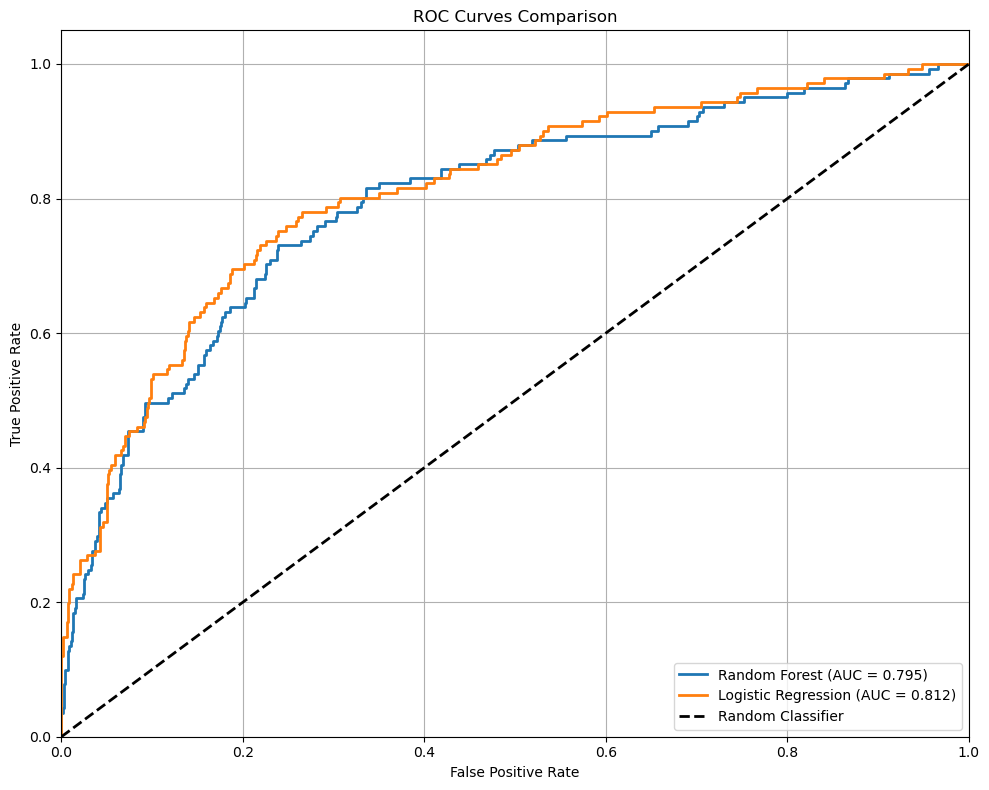

In [12]:
# Create a figure for ROC curve visualization
plt.figure(figsize=(10, 8))

# Loop through each model to plot its ROC curve
for name, model in best_models.items():
    # Generate probability predictions using cross-validation
    y_score = cross_val_predict(model, X_train_scaled, y_train, cv=cv, method='predict_proba')[:, 1]
    
    # Calculate false positive rate, true positive rate and ROC AUC
    fpr, tpr, _ = roc_curve(y_train, y_score)
    roc_auc = auc(fpr, tpr)
    
    # Add this model's ROC curve to the plot
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.3f})')

# Add diagonal line representing random classifier performance
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')

# Set plot formatting and labels
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

In [13]:
# Calculate and display model performance metrics on test data
print("\nModel Performance on Test Data:")
print("-" * 50)

# Create a dictionary to store test scores
test_scores = {}

# Evaluate each model in best_models
for name, model in best_models.items():
    # Make predictions on the test set
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc_value = roc_auc_score(y_test, y_pred_proba)
    
    # Store metrics in dictionary
    test_scores[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc_value
    }
    
    # Display metrics for current model
    print(f"\n{name} Test Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc_value:.4f}")
    
    # Generate and display confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"Confusion Matrix:")
    print(f"[[{cm[0][0]} {cm[0][1]}]")
    print(f" [{cm[1][0]} {cm[1][1]}]]")

# Create side-by-side model comparison
test_scores_df = pd.DataFrame(test_scores)
print("\nModel Comparison on Test Data:")
print(test_scores_df)



Model Performance on Test Data:
--------------------------------------------------

Random Forest Test Metrics:
Accuracy: 0.8981
Precision: 0.8500
Recall: 0.4857
F1 Score: 0.6182
ROC AUC: 0.8535
Confusion Matrix:
[[168 3]
 [18 17]]

Logistic Regression Test Metrics:
Accuracy: 0.7961
Precision: 0.4407
Recall: 0.7429
F1 Score: 0.5532
ROC AUC: 0.8685
Confusion Matrix:
[[138 33]
 [9 26]]

Model Comparison on Test Data:
           Random Forest  Logistic Regression
Accuracy        0.898058             0.796117
Precision       0.850000             0.440678
Recall          0.485714             0.742857
F1 Score        0.618182             0.553191
ROC AUC         0.853467             0.868505


### Based on cross-validation results, I choose to use Random Forest. Although its F1 score is slightly lower than that of logistic regression, it misclassifies significantly fewer positive cases, making predictions about RCC offer acceptance more reliable. Test scores confirm this.

### The logistic regression model emphasizes categorical job roles, relationship satisfaction, and marital status, suggesting it relies more on demographic and role-related patterns to predict RCC acceptance. In contrast, the Random Forest model highlights OverTime status, tenure-related features, and compensation-related variables, pointing to more behavioral and structural factors. This contrast shows how logistic regression captures linear associations with categorical features, while Random Forest picks up on complex, non-linear patterns tied to workload, tenure, and compensation. The optimizer’s selection of the Burnout, High-Turnover, and Compensation Imbalance groups aligns well with the most influential features identified by Random Forest, reinforcing the reliability of the overall analysis.


# Likelihood Predictions on Lyon Data

In [14]:
# Load the Lyon employee data for prediction
prediction_data = pd.read_csv('employee_attrition_lyon.csv')
prediction_data.head()

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,NaN,Travel_Rarely,866.0,Sales,NaN,3,Medical,1,1469,4,...,4,80,0,6,4,3,5,4,1,3
1,53.0,Travel_Rarely,1084.0,Research & Development,13.0,2,Medical,1,250,4,...,3,80,2,5,3,3,4,2,1,3
2,24.0,Travel_Rarely,240.0,Human Resources,22.0,1,Human Resources,1,1714,4,...,3,80,1,1,2,3,1,0,0,0
3,45.0,Travel_Rarely,1339.0,Research & Development,7.0,3,Life Sciences,1,86,2,...,3,80,1,25,2,3,1,0,0,0
4,36.0,Travel_Rarely,1396.0,Research & Development,NaN,2,Life Sciences,1,304,4,...,4,80,0,16,3,4,13,11,3,7


In [15]:
# Apply the same one-hot encoding process to the Lyon data
prediction_data_encoded = one_hot_encode(prediction_data)
prediction_data_encoded.head()

Categorical columns to encode: ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'Over18', 'OverTime']
Shape before encoding: (441, 34)
Shape after encoding: (441, 47)


,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes
0,NaN,866.0,NaN,3,1,1469,4,84,3,2,...,0,0,0,0,0,1,0,0,1,0
1,53.0,1084.0,13.0,2,1,250,4,57,4,2,...,0,0,1,0,0,0,0,0,0,0
2,24.0,240.0,22.0,1,1,1714,4,58,1,1,...,0,0,0,0,0,0,0,1,0,0
3,45.0,1339.0,7.0,3,1,86,2,59,3,3,...,0,0,0,0,1,0,0,0,0,0
4,36.0,1396.0,NaN,2,1,304,4,62,3,2,...,1,0,0,0,0,0,0,0,1,0


In [16]:
# Handle missing values by imputing with column means
print("\nFilling NA values with mean in encoded dataframe:")
prediction_data_encoded_clean = prediction_data_encoded.fillna(prediction_data_encoded.mean())
print(f"Shape before filling NA: {prediction_data_encoded.shape}")
print(f"Shape after filling NA: {prediction_data_encoded_clean.shape}")
print(f"Number of NA values filled: {prediction_data_encoded.isna().sum().sum()}")

# Remove non-predictive columns that don't contribute to the model
print("\nDropping EmployeeCount, EmployeeNumber, StandardHours columns:")
columns_to_drop = ['EmployeeCount', 'EmployeeNumber', 'StandardHours']
prediction_data_encoded_clean = prediction_data_encoded_clean.drop(columns=columns_to_drop, errors='ignore')
print(f"Shape after dropping specified columns: {prediction_data_encoded_clean.shape}")


Filling NA values with mean in encoded dataframe:
Shape before filling NA: (441, 47)
Shape after filling NA: (441, 47)
Number of NA values filled: 123

Dropping EmployeeCount, EmployeeNumber, StandardHours columns:
Shape after dropping specified columns: (441, 44)


In [17]:
prediction_data_encoded_clean.head()

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes
0,38.0,866.0,9.459948,3,4,84,3,2,1,8463,...,0,0,0,0,0,1,0,0,1,0
1,53.0,1084.0,13.000000,2,4,57,4,2,1,4450,...,0,0,1,0,0,0,0,0,0,0
2,24.0,240.0,22.000000,1,4,58,1,1,3,1555,...,0,0,0,0,0,0,0,1,0,0
3,45.0,1339.0,7.000000,3,2,59,3,3,1,9724,...,0,0,0,0,1,0,0,0,0,0
4,36.0,1396.0,9.459948,2,4,62,3,2,2,5914,...,1,0,0,0,0,0,0,0,1,0


In [18]:
# Scale the data
prediction_data_scaled = scaler.fit_transform(prediction_data_encoded_clean)

In [19]:
# Retrieve the Random Forest model from best_models dictionary
random_forest_model = best_models['Random Forest']

# Generate probability predictions using the Random Forest model for employee attrition
attrition_probabilities = random_forest_model.predict_proba(prediction_data_scaled)

# Extract the probability values for the positive class (Attrition=Yes) representing attrition likelihood
attrition_likelihood = attrition_probabilities[:, 1]

# Append the calculated likelihood values to the original dataset
prediction_data['Likelihood_of_Leaving'] = attrition_likelihood

# Output the first 10 likelihood predictions for review
print("Predicted likelihood of employees leaving the company:")
result_display = prediction_data[['Likelihood_of_Leaving']].head(10)
print(result_display)

# Identify employees with high attrition risk (greater than 80% likelihood)
high_likelihood = prediction_data[prediction_data['Likelihood_of_Leaving'] > 0.8]
print(f"\nNumber of high-likelihood employees (>80% likelihood of leaving): {len(high_likelihood)}")


Predicted likelihood of employees leaving the company:
   Likelihood_of_Leaving
0               0.749416
1               0.472590
2               0.531737
3               0.345062
4               0.582742
5               0.575912
6               0.652103
7               0.647434
8               0.562644
9               0.616164

Number of high-likelihood employees (>80% likelihood of leaving): 35


In [20]:
# Creating a DataFrame containing only the likelihood values
likelihood_df = pd.DataFrame({'Likelihood_of_Leaving': attrition_likelihood})

# Exporting to CSV file without index column to preserve the original order
likelihood_df.to_csv('attrition_prediction.csv', index=False)

# Grouping Logic

In [21]:
def compute_rcc_compensation(row):
    years = row["YearsAtCompany"]
    monthly_salary = row["MonthlyIncome"]

    if years < 0.67:  # Less than 8 months
        return 0

    base_years = min(years, 10)
    extra_years = max(years - 10, 0)

    base_comp = base_years * (1/4) * monthly_salary
    extra_comp = extra_years * (1/3) * monthly_salary

    return base_comp + extra_comp

# Calculate base compensation for each employee based on tenure
prediction_data_encoded_clean["BaseCompensation"] = prediction_data_encoded_clean.apply(
    compute_rcc_compensation, axis=1
)

# Calculate enhanced RCC offer by adding 3 months' salary to the base compensation
prediction_data_encoded_clean["RCCOfferCompensation"] = (
    prediction_data_encoded_clean["BaseCompensation"] +
    3 * prediction_data_encoded_clean["MonthlyIncome"]
)


In [22]:
# Combining prediction data with likelihood values
grouping_df = prediction_data_encoded_clean.copy()

# Add the likelihood of leaving to grouping_df from likelihood_df
grouping_df['Likelihood_of_Leaving'] = likelihood_df['Likelihood_of_Leaving']

# Define all group names
group_names = [
    'At-Risk Low Performers',
    'Burnout',
    'Junior High-Turnover',
    'Unengaged but Trained',
    'Bad Job Embeddedness',
    'Early Career Uncommitted',
    'Compensation Imbalance'
]

# Initialize columns for each group with zeros
for group in group_names:
    grouping_df[group] = 0

# Group A: "At-Risk Low Performers"
# Criteria: Low job satisfaction (<=2) and low job level (<=2)
mask_a = (
    (grouping_df["JobSatisfaction"] <= 2) &
    (grouping_df["JobLevel"] <= 2)
)
grouping_df.loc[mask_a, 'At-Risk Low Performers'] = 1

# Group B: "Burnout"
# Criteria: poor work-life balance (<=2), and working overtime (OverTime_Yes == 1)
mask_b = (
    (grouping_df["WorkLifeBalance"] <= 2) &
    (grouping_df["OverTime_Yes"] == 1)
)
grouping_df.loc[mask_b, 'Burnout'] = 1

# Group C: "Junior High-Turnover"
# Criteria: entry-level (JobLevel == 1), short tenure (<4 years) and history of job hopping (NumCompaniesWorked > 3)
mask_c = (
    (grouping_df["JobLevel"] == 1) &
    (grouping_df["YearsAtCompany"] < 4) &
    (grouping_df["NumCompaniesWorked"] > 3)
)
grouping_df.loc[mask_c, 'Junior High-Turnover'] = 1

# Group D: "Unengaged but Trained"
# Criteria: At least two training sessions last year, but low job involvement (<=2) and low job satisfaction (<=2)
mask_d = (
    (grouping_df["TrainingTimesLastYear"] >= 2) &
    (grouping_df["JobInvolvement"] <= 2) &
    (grouping_df["JobSatisfaction"] <= 2)
)
grouping_df.loc[mask_d, 'Unengaged but Trained'] = 1

# Group E: "Bad Job Embeddedness"
# Criteria: Higher than average MonthlyIncome, less than 10 years at the company, relationship status 1 and poor work-life balance
mask_e = (
    (grouping_df["RelationshipSatisfaction"] == 1) &
    (grouping_df["WorkLifeBalance"] <= 2)
)
grouping_df.loc[mask_e, 'Bad Job Embeddedness'] = 1

# Group F: "Early Career Uncommitted"
# Criteria: Moderately short tenure (>=2 and <5 years) with low engagement (JobInvolvement <=2 and JobSatisfaction <=2)
mask_f = (
    (grouping_df["YearsAtCompany"] < 5) &
    (grouping_df["JobInvolvement"] <= 2) &
    (grouping_df["JobSatisfaction"] <= 2)
)
grouping_df.loc[mask_f, 'Early Career Uncommitted'] = 1

# Group G: "Compensation Imbalance"
# Criteria: RCCOfferCompensation lower than mean but MonthlyIncome higher than mean
avg_rcc_compensation = grouping_df["RCCOfferCompensation"].mean()
avg_monthly_income = grouping_df["MonthlyIncome"].mean()
mask_g = (
    (grouping_df["RCCOfferCompensation"] < avg_rcc_compensation) &
    (grouping_df["MonthlyIncome"] > avg_monthly_income)
)
grouping_df.loc[mask_g, 'Compensation Imbalance'] = 1

# Create a column that shows if an employee belongs to any group
grouping_df['In_Any_Group'] = (grouping_df[group_names].sum(axis=1) > 0).astype(int)

# For calculating means, drop the non-numeric columns
numeric_df = grouping_df.drop(['In_Any_Group'], axis=1)

# Calculate mean values for all employees in the dataset
all_employees_mean = numeric_df.mean(numeric_only=True)

# Create a dictionary to store group statistics
group_stats = {}

# Calculate statistics for each group
for group_name in group_names:
    # Identify employees in the group
    in_group = grouping_df[group_name] == 1
    if in_group.sum() > 0:  # Only calculate if there are employees in the group
        high_likelihood_count = ((grouping_df['Likelihood_of_Leaving'] > 0.5) & in_group).sum()
        total_likelihood = grouping_df.loc[in_group, 'Likelihood_of_Leaving'].sum()
        group_stats[group_name] = {
            'count': in_group.sum(),
            'high_likelihood_count': high_likelihood_count,
            'total_likelihood': total_likelihood,
            'avg_likelihood': total_likelihood / in_group.sum(),
            'means': numeric_df[in_group].mean(numeric_only=True)
        }

# Display counts for each group
print("Count of employees in each group:")
for group_name, stats in group_stats.items():
    print(f"{group_name}: {stats['count']}")

# Display counts of employees with likelihood > 0.5 in each group
print("\nCount of employees with likelihood > 0.5 in each group:")
for group_name, stats in group_stats.items():
    pct = (stats['high_likelihood_count'] / stats['count'] * 100) if stats['count'] > 0 else 0
    print(f"{group_name}: {stats['high_likelihood_count']} ({pct:.1f}%)")

# Display accumulated likelihood for each group
print("\nAccumulated likelihood of leaving for each group:")
for group_name, stats in group_stats.items():
    print(f"{group_name}: {stats['total_likelihood']:.2f} (Avg: {stats['avg_likelihood']:.2f})")


# Display mean values for key features by group
print("\nMean values for key features by group:")
key_features = ["Age", "Gender_Male", "MaritalStatus_Married", "MaritalStatus_Single", "Likelihood_of_Leaving"]

# Create a DataFrame for displaying means with groups as rows and features as columns
means_df = pd.DataFrame(index=['All Employees'] + list(group_stats.keys()), columns=key_features)

# Fill in the data
means_df.loc['All Employees'] = all_employees_mean[key_features]
for group_name in group_stats:
    means_df.loc[group_name] = group_stats[group_name]['means'][key_features]

print(means_df)


Count of employees in each group:
At-Risk Low Performers: 114
Burnout: 34
Junior High-Turnover: 24
Unengaged but Trained: 37
Bad Job Embeddedness: 15
Early Career Uncommitted: 13
Compensation Imbalance: 30

Count of employees with likelihood > 0.5 in each group:
At-Risk Low Performers: 78 (68.4%)
Burnout: 20 (58.8%)
Junior High-Turnover: 24 (100.0%)
Unengaged but Trained: 20 (54.1%)
Bad Job Embeddedness: 9 (60.0%)
Early Career Uncommitted: 12 (92.3%)
Compensation Imbalance: 19 (63.3%)

Accumulated likelihood of leaving for each group:
At-Risk Low Performers: 67.84 (Avg: 0.60)
Burnout: 18.14 (Avg: 0.53)
Junior High-Turnover: 16.81 (Avg: 0.70)
Unengaged but Trained: 19.37 (Avg: 0.52)
Bad Job Embeddedness: 8.21 (Avg: 0.55)
Early Career Uncommitted: 8.54 (Avg: 0.66)
Compensation Imbalance: 16.44 (Avg: 0.55)

Mean values for key features by group:
                                Age Gender_Male MaritalStatus_Married  \
All Employees                  38.0    0.600907              0.437642   

In [23]:
excel_df = grouping_df.copy()
# Create a copy of the grouping DataFrame for Excel export
columns_to_keep = [
    'MonthlyIncome', 
    'Department_Research & Development', 
    'Department_Sales', 
    'BaseCompensation', 
    'RCCOfferCompensation', 
    'Likelihood_of_Leaving'
]

# Add group columns to the columns to keep
group_columns = [col for col in grouping_df.columns if col in group_names]
columns_to_keep.extend(group_columns)

# Check which specified columns actually exist in the DataFrame
available_columns = [col for col in columns_to_keep if col in excel_df.columns]

# Print warning for any missing columns
missing_columns = set(columns_to_keep) - set(available_columns)
if missing_columns:
    print(f"Warning: The following columns were not found in the DataFrame: {missing_columns}")

# Filter DataFrame to only include available columns from the list
excel_df = excel_df[available_columns]

# Calculate Department_Human Resources column
# Set to 1 when employee is neither in R&D nor Sales departments
excel_df['Department_Human Resources'] = ((excel_df['Department_Research & Development'] == 0) & 
                                         (excel_df['Department_Sales'] == 0)).astype(int)

# Reorder columns to group all department columns together
cols = excel_df.columns.tolist()
dept_sales_index = cols.index('Department_Sales')
cols.remove('Department_Human Resources')
cols.insert(dept_sales_index + 1, 'Department_Human Resources')
excel_df = excel_df[cols]

In [24]:
# Export the processed DataFrame to Excel for further analysis
# Index is excluded as it's not needed in the exported file
excel_df.to_excel('input_data.xlsx', index=False)